###  Classification Targets

Target - the target is an ordinal variable indicating groups of income levels.

1 = extreme poverty \
2 = moderate poverty \
3 = vulnerable households \
4 = non vulnerable households


https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/data

### ✅ Setup

Install the required packages abd declare the global variables.

In [79]:
%pip install -r ../requirements.txt -q

8092.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [176]:
DATA_DIR = '../data/'
TEST_CSV = DATA_DIR + 'test.csv'
TRAIN_CSV = DATA_DIR + 'train.csv'

TARGET_COLUMN = "Target"
ID_COLUMN = "Id"
HOUSE_HOLD_ID_COLUMN = "idhogar"

DEFAULT_RANDOM_STATE = 369
DEFAULT_TEST_SIZE = 0.3
DEFAULT_VALIDATION_SIZE = 0.3
DEFAULT_CROSS_VALIDATION = 5

### ✅ Submission

This section will contain a reusable utility function to submit the predictions to the competition.

In [74]:
def export_submission(df):
    df.to_csv('submission.csv', index=False)

### ✅ Data Overview

In [187]:
csv_data = pd.read_csv(TRAIN_CSV)
csv_data.describe(include = 'all')

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,9557,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
unique,9557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_279628684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,NaN,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,NaN,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,NaN,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,NaN,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,NaN,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000


In [188]:
print(f"Total number of rows: {len(csv_data)}")

Total number of rows: 9557


In [192]:
csv_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Text(0.5, 1.0, 'Histogram of People by Class')

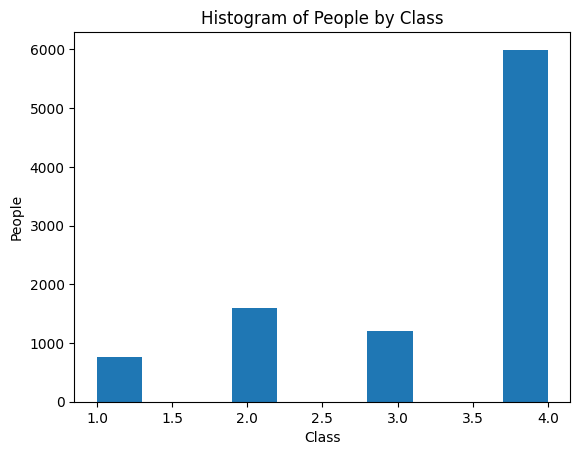

In [193]:
ax = csv_data[TARGET_COLUMN].hist()
ax.grid(False) 
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('Histogram of People by Class')

### ✅  Data Preparation

The data preparation will:
- Remove unnecessary columns (ID, Target, idhogar)
- Fill missing values with the median. Because the data is skewed, the median is a better choice than the mean.
- Encode categorical variables

> Note: *idhogar* is a unique identifier for each household.

To prepare the data we use `Pipeline` and `ColumnTransformer` from `sklearn`. It is possible to combine the estimator and the transformer in a single pipeline, but we will keep the data preparation and the model training separate as we will use the same data preparation for all models.

In [194]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy


def fill_and_encode(data):
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = data.select_dtypes(include=['object', 'bool']).columns  

    num_transformer = SimpleImputer(strategy='median') 
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    fit_data = pipeline.fit_transform(data)
    
    onehot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    onehot_cols = [f"{col}_{val}" for col, vals in zip(cat_cols, onehot_encoder.categories_) for val in vals]
    feature_names = np.append(num_cols, onehot_cols)
    return pd.DataFrame(fit_data, columns = feature_names)

def remove_columns(data):
    cols_to_remove = [ ID_COLUMN, TARGET_COLUMN, HOUSE_HOLD_ID_COLUMN ]
    for col in cols_to_remove:
        if col in data.columns:
            data = data.drop(columns = col)
    return data

def prepare(csv_path = None, data = None):
    if csv_path is None and data is None:
        raise ValueError("Either csv_path or data must be provided")
    if csv_path is not None and data is not None:
        raise ValueError("Only one of csv_path or data must be provided")
    raw_data = pd.read_csv(csv_path) if csv_path is not None else deepcopy(data)
    raw_data = remove_columns(raw_data)
    return fill_and_encode(raw_data)

In [186]:
csv_data.shape

(9557, 143)

In [195]:
TARGET = csv_data[TARGET_COLUMN]
DATA = prepare(data=csv_data)
print(f"TARGET: {TARGET.shape} | DATA: {DATA.shape}")

TARGET: (9557,) | DATA: (9557, 212)


In [198]:
DATA.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,edjefa_21,edjefa_3,edjefa_4,edjefa_5,edjefa_6,edjefa_7,edjefa_8,edjefa_9,edjefa_no,edjefa_yes
0,190000.0,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,135000.0,0.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,130000.0,0.0,8.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,180000.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,180000.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [196]:
X_train, X_test, y_train, y_test = train_test_split(DATA, TARGET, test_size=DEFAULT_TEST_SIZE, random_state=RANDOM_STATE)

In [197]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6689, 212), (6689,), (2868, 212), (2868,))

### ✅ Sampling

The training data is imbalanced. There is sinnificantly higher number of data for class 4 than the other classes. This will be addressed by experimenting with different sampling. The oversampling will be done only on the training data. The test data will remain unchanged.

- **Oversampling:** will increase the number of data for the minority classes. For this we use the `RandomOverSampler` from the `imblearn` library.

- **Undersampling:** will decrease the number of data for the majority classes. For this we use the `RandomUnderSampler` from the `imblearn` library.

- **Over and Under Sampling** will increase the number of data for the minority classes and decrease the number of data for the majority classes. For this we use the `SMOTETomek` from the `imblearn` library.


In [121]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

def oversample(X, y):
    ros = RandomOverSampler(random_state=0)
    return ros.fit_resample(X, y)

def undersample(X, y):
    ros = RandomUnderSampler(random_state=0)
    return ros.fit_resample(X, y)

def smotsample(X, y):
    ros = SMOTETomek(sampling_strategy='auto')
    return ros.fit_resample(X, y)

Text(0.5, 1.0, 'People by Class (oversampled)')

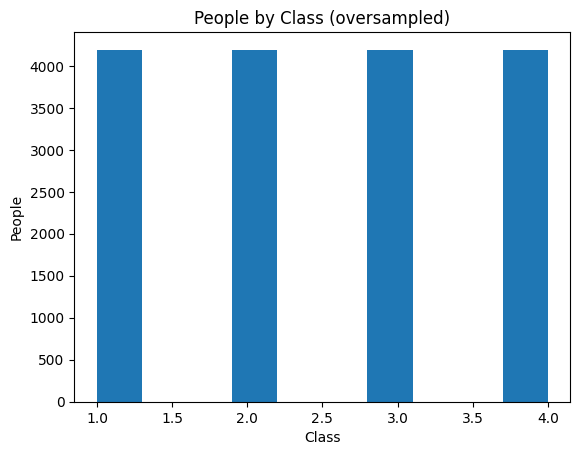

In [122]:
oversampled_X, oversampled_y = oversample(X_train, y_train)
ax = oversampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (oversampled)')

Text(0.5, 1.0, 'People by Class (undersampled)')

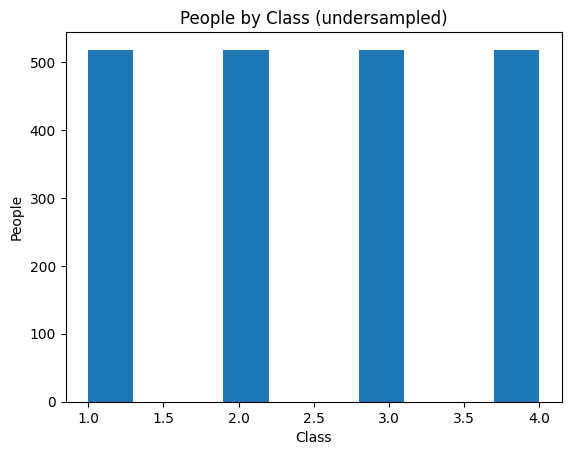

In [92]:
undersampled_X, undersampled_y = undersample(X_train, y_train)
ax = undersampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (undersampled)')

Text(0.5, 1.0, 'People by Class (smotsampled)')

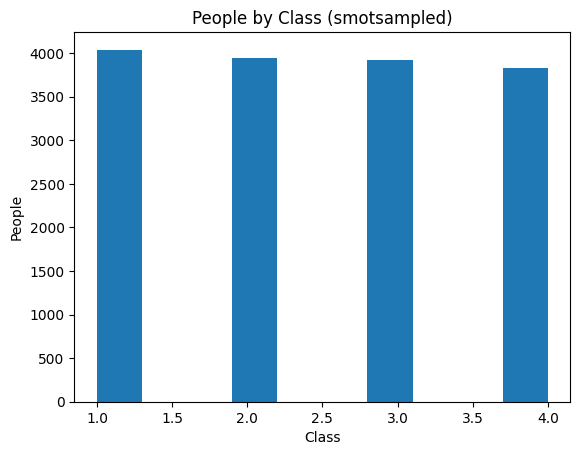

In [93]:
smotsampled_X, smotsampled_y = smotsample(X_train, y_train)
ax = smotsampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (smotsampled)')

### ✅ Ensemble learning

#### ✅ Shared Code

We would like to experiment with different models and different configuration and different hyperparameters. To ease the process and avoid code duplication we use reusable functions for:

- **Model training** 
- **Model evaluation**
- **Visualization**
- **Important features**

In the training the model we use `GridSearchCV` for hyperparameter tuning. The `GridSearchCV` will use weighted F1 score as the scoring function. The `GridSearchCV` will use 5-fold cross validation by default.

In [113]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV



def train_model(
    model, 
    train_x, 
    train_y, 
    param_grid = None, 
    test_size=DEFAULT_VALIDATION_SIZE, 
    cv = DEFAULT_CROSS_VALIDATION):

    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=test_size, random_state=42)

    if param_grid is not None:
        model = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted')
        
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, model.predict(X_test))
    return model, accuracy

def important_features(trained_model):
    columns = pd.read_csv(TRAIN_CSV)
    columns = columns.drop(TARGET_COLUMN, axis=1)
    columns = columns.drop(ID_COLUMN, axis=1)
    columns = columns.columns
    if trained_model.__class__ == GridSearchCV:
        trained_model = trained_model.best_estimator_
        
    feature_importance = pd.DataFrame(trained_model.feature_importances_,
                                    index = columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
    return feature_importance

#### ✅ AdaBoost

In [123]:
ada_boost_param_grid = {
    # run this when you have time
    # 'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 1],
    # 'base_estimator__max_depth': [2 , 3, 5, 7, 10],
    # 'base_estimator__min_samples_leaf': [3, 5, 10, 20]

    'learning_rate': [0.01],
    'estimator__max_depth': [3],
    'estimator__min_samples_leaf': [5]
}

ada_boost_model, training_accuracy = train_model(AdaBoostClassifier(estimator=DecisionTreeClassifier()), oversampled_X, oversampled_y, param_grid=ada_boost_param_grid)
print(f"Best parameters: \n{ada_boost_model.best_params_}")

Best parameters: 
{'estimator__max_depth': 3, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.01}


In [124]:
print(f"AdaBoost training accuracy: {training_accuracy}")

AdaBoost training accuracy: 0.48578811369509045


((16768, 3200), (16768,))

In [125]:
pd.DataFrame(ada_boost_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__min_samples_leaf,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,63.36257,3.516577,0.938484,0.232373,3,5,0.01,"{'estimator__max_depth': 3, 'estimator__min_sa...",0.482464,0.509766,0.470141,0.501919,0.507579,0.494374,0.015475,1


array([[1.3e+05, 0.0e+00, 7.0e+00, ..., 0.0e+00, 1.0e+00, 0.0e+00],
       [1.3e+05, 0.0e+00, 4.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       [1.3e+05, 0.0e+00, 2.0e+00, ..., 0.0e+00, 1.0e+00, 0.0e+00],
       ...,
       [1.3e+05, 0.0e+00, 4.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       [1.3e+05, 0.0e+00, 7.0e+00, ..., 0.0e+00, 1.0e+00, 0.0e+00],
       [1.3e+05, 0.0e+00, 7.0e+00, ..., 0.0e+00, 1.0e+00, 0.0e+00]])

In [155]:
ada_boost_model.best_estimator_.feature_importances_

array([0.        , 0.00203454, 0.0068954 , ..., 0.        , 0.00218852,
       0.        ])

In [129]:
pd.DataFrame(ada_boost_model.best_estimator_.estimators_[0].feature_importances_)

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
3195,0.0
3196,0.0
3197,0.0
3198,0.0


In [114]:
important_features(ada_boost_model)

ValueError: Shape of passed values is (3200, 1), indices imply (141, 1)

### Gradient Boosting

In [16]:
gradient_boost_param_grid = {
    # Run this at before going to sleep
    # 'learning_rate': [0.01, 0.1, 0.5],
    # 'max_depth': [3, 5, 7],
    # 'min_samples_leaf': [5, 10, 20]

    'learning_rate': [0.1],
    'max_depth': [3],
    'min_samples_leaf': [5]
}

gradient_boost_model, training_accuracy = train_model(GradientBoostingClassifier(), undersampled_X, undersampled_y, param_grid=gradient_boost_param_grid)
print(f"GradientBoost training accuracy: {training_accuracy}")


GradientBoost training accuracy: 0.5330459770114943


In [52]:
gradient_boost_model.__class__

sklearn.model_selection._search.GridSearchCV

In [53]:
important_features(gradient_boost_model)

,importance
SQBdependency,0.112112
meaneduc,0.108947
SQBmeaned,0.094643
SQBhogar_nin,0.052052
qmobilephone,0.042270
...,...
instlevel2,0.000000
instlevel4,0.000000
instlevel9,0.000000
instlevel8,0.000000


### XGBoost

In [72]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def train_xgboost_model(train, xgb_params, test_size=0.2):
    train = train[:]
    X = train.drop(prediction_column, axis=1)
    y = train[prediction_column]
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    train_labels = le.fit_transform(y_train)
    val_labels = le.transform(y_test)

    dtrain = xgb.DMatrix(X_train, label=train_labels, enable_categorical=True)
    dval = xgb.DMatrix(X_test, label=val_labels, enable_categorical=True)
    eval_set = [(dtrain, 'train'), (dval, 'eval')]
    
    xgb_model = xgb.train(
        xgb_params, 
        dtrain, 
        num_boost_round=1000, 
        evals=eval_set, 
        early_stopping_rounds=10, 
        verbose_eval=False
    )
    accuracy = accuracy_score(val_labels, xgb_model.predict(dval))

    return xgb_model, accuracy

def xgb_feature_importance(xgb_model):
    feature_importance = xgb_model.get_score(importance_type='weight')
    feature_importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })
    feature_importance_df.sort_values(by='Importance', ascending=False).head(5)
    return feature_importance_df

In [73]:
xgb_params = {
    "objective": "multi:softmax", 
    "num_class": 4,
    "eval_metric": "merror"
}

xgb_model, training_accuracy = train_xgboost_model(train, xgb_params)
print(f"XGBoost training accuracy: {training_accuracy}")

XGBoost training accuracy: 0.9257322175732218


In [74]:
feature_importance_df = xgb_feature_importance(xgb_model)
feature_importance_df

,Feature,Importance
0,v2a1,750.0
1,hacdor,33.0
2,rooms,838.0
3,hacapo,14.0
4,v14a,12.0
...,...,...
117,area1,290.0
118,age,1131.0
119,SQBedjefe,1046.0
120,SQBdependency,799.0


In [ ]:
def hetrogeneous_ensemble_with_cnn(ada_boost_model, gradient_boost_model, xgb_model, train_x, train_y):
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.4, random_state=42)
    # TODO: combination of ensemble models with CNN
   
    

## Tasks
- ✅ A working setup for Ensemble learning with AdaBoost, Gradient Boosting and XGBoost
- ✅ Feature importance for the different models
- ✅ Compare the different models accuracy
- ✅ Add different data preprocessing methods
- ✅ Balance dataset by undersampling, and possibly oversampling
- ❌ Find optimum parameter for the different models
- ❌ Performance Metric
- ❌ Heterogeneous ensemble with simple CNN